# Exploratory Data Analysis of the Waymo Open Dataset
## Object Attributes

This Jupyter Notebook explores Object Instance Data extracted from the labels of approximately 500,000 objects over 8,000 frames of the Waymo Open Dataset. 


In [3]:
import os
import tensorflow as tf
import math
import numpy as np
import pandas as pd
import itertools
import collections
import scipy.stats as sts
#import plot_functions as pf

In [4]:
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

Read in 'objects500k.csv'. This csv file contains nearly 500,000 objects taken from 8,000 frames of the Waymo dataset.

In [5]:
objects_df = pd.read_csv('objects500k.csv')

The objects contain location data broken down into x, y, z coordinates. Below, we calculate the distance of each object from the Waymo car in the x-y plane. 

In [6]:
objects_df['distance'] = np.sqrt(objects_df['location_x']**2 + objects_df['location_y']**2)

The Objects DataFrame contains the following columns:

In [7]:
objects_df.head()

,Unnamed: 0,category,dimension_height,dimension_length,dimension_width,heading,location_x,location_y,location_z,distance
0,0,pedestrian,1.889434,1.036285,0.869548,28.046370,-21.392696,34.256657,-0.167213,40.387696
1,1,pedestrian,1.650000,0.905959,0.784573,-176.548462,10.391662,20.009092,0.140395,22.546627
2,2,pedestrian,2.000000,0.655752,0.789083,154.997238,67.121521,0.957747,1.680581,67.128354
3,3,pedestrian,2.100000,0.734008,0.863620,89.197525,28.183521,-33.817711,3.271440,44.022136
4,4,pedestrian,1.642014,0.941461,0.776469,-169.396439,-65.372452,17.677683,-0.608567,67.720439


We are especially interested in the behaviour of each object type. The object type labels in the Waymo Dataset consist of **Pedestrians**, **Cyclists**, **Vehicles**, and **Signs**.

We're mostly interested in the three object types that are *mobile*; we'll take a brief look at road signs, but our analysis will predominantly focus on **Pedestrians** and **Vehicles**. The number **Cyclist** objects is surpsrisingly limited as we'll see shortly!

Below, we'll make copies of our Objects DataFrame for each object type. 

In [8]:
pedestrians = objects_df[objects_df['category'] == 'pedestrian'].copy()
cyclists = objects_df[objects_df['category'] == 'cyclist'].copy()
vehicles = objects_df[objects_df['category'] == 'vehicle'].copy()
signs = objects_df[objects_df['category'] == 'sign'].copy()

To begin understanding this data, let's visualize the distribution of objects with respect to the Waymo Car. To do this, we'll plot the X- and Y-location data for each object instance on a 2D scatter plot. 

We've written a function we'll call below to plot this, which can be found in 'plot_functions.py'.

In [25]:
def getImage(path):
    return OffsetImage(plt.imread(path))

def plot_obj_pc(object_type, alpha=0.5):
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    for each in object_type:
        xdata = each['location_x']
        ydata = each['location_y']
        ax.scatter(xdata, ydata, alpha=alpha, s=5)
        ax.legend(loc='best')
    ax.legend(("Vehicle", "Pedestrian", "Cyclist"), loc='best')
    x = 0
    y = 0
    ax.scatter(x, y) 
    ax.set_title('Scatter Plot of Object Class Instances')
    ab = AnnotationBbox(getImage('waymo_top.png'), (x, y), frameon=False)
    ax.add_artist(ab)
    ax.axis('off')

In [26]:
def plot_obj_pc_multi(object_type, alpha=0.25):
    
    fig, ax = plt.subplots(1, 3, figsize=(10,3))
    
    color = ['blue','orange','green']
    labels=['Vehicle', 'Pedestrian', 'Cyclist']
    
    for i, each in enumerate(object_type):
        xdata = each['location_x']
        ydata = each['location_y']
        ax[i].scatter(xdata, ydata, alpha=alpha,s=0.33, color=color[i])
        ax[i].set_title(labels[i])
        x = 0
        y = 0
        ax[i].scatter(x, y) 
    
        ab = AnnotationBbox(getImage('waymo_top.png'), (x, y), frameon=False)
        ax[i].add_artist(ab)
        ax[i].axis('off')

There are nearly 500,000 object instances in our Objects Dataframe! Although we can adjust the point size and opacity in our scatter plot, this is still a lot to take in in one graph. Therefore, we've called our function on a *sample* of the **Vehicle** and **Pedestrian** data. Note that *all* **Cyclist** instances are presented in our map because the instance is so rare; only 2,629 **Cyclist** instances occured out of the nearly 500,000 object instances in this DataFrame. The sample size of the other two object classes are based on the proportion of the classes with respect to the total number of object instances. 

The three smaller maps present a nearly-equal sample of each object class on its own.

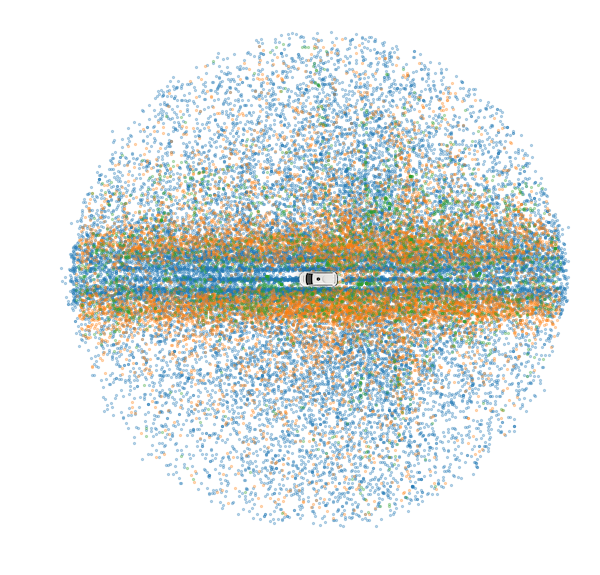

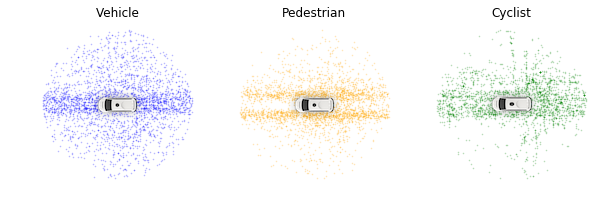

In [28]:
plot_obj_pc([vehicles.sample(25000), pedestrians.sample(10000), cyclists], alpha=0.3)
#plt.savefig('scatter_plot_lidar.png',bbox_inches='tight')
plot_obj_pc_multi([vehicles.sample(3000), pedestrians.sample(3000), cyclists])
#plt.savefig('3_scatter_plot_lidar.png',bbox_inches='tight')


We quickly notice from the maps above that the instances appear to be concentrated in line with our Waymo Car along the "X axis." This isn't a coincidence; think carefully about how traffic moves, and you'll see that these concentrations of points are an artifact of lanes and sidewalks that guide us along the road. 

In [12]:
def plot_subgroup_hist(df, sub_a, sub_b):
    '''
    Displays information of 2 sub groups of a data set 
    '''
    
    fig, axs = plt.subplots(1,3, figsize=(15, 3))
    for col_name, ax in zip(df.columns, axs.flatten()):
        bins = np.linspace(df[col_name].min(), df[col_name].max(), 30)
        height, binz = np.histogram(sub_a[col_name], bins=bins, density=True)
        bp1 = ax.bar(bins[:-1], height, .5*(bins[1]-bins[0]),
                     alpha=0.5, label=sub_a, color='g')
        height, binz = np.histogram(sub_b[col_name], bins=bins, density=True)
        bp2 = ax.bar(bins[:-1]+.5*(bins[1]-bins[0]), height,
                     .5*(bins[1]-bins[0]), color='b', alpha=.5)
        ax.set_title(str(col_name).split('_', 1)[-1].title())
        ax.legend((bp1[0], bp2[0]), ("Pedestrian", "Vehicle"), loc='best')

    plt.tight_layout()

    return fig, ax

### Object Class Dimensions

Each object instance is labeled with a 3D bounding box. You can see an example of how this looks below. The yellow bounding boxes are Vehicles, red are Pedestrians, and blue are Signs.

<img src="3D-bounding-box-ex.jpg">

These bounding boxes approxmate the dimensions of each of our object instances. We can use this to get a rough idea of the distribution of the height, width, and length of different object classes, and compare the size between classes. 

In the plots below, we compare the height, width, and length of **Pedestrian**, **Cycle**, and **Vehicle** type objects.

In [870]:
def plot_subgroup_multi_hist(df, subs, labels):
    num_subs = len(subs)
    bp = []
    fig, axs = plt.subplots(1,3, figsize=(15, 3))
    for col_name, ax in zip(df.columns, axs.flatten()):
        bins = np.linspace(df[col_name].min(), df[col_name].max(), 30)
        
        for sub in subs:
            height, binz = np.histogram(sub[col_name], bins=bins, density=True)
            bp.append(ax.bar(bins[:-1], height, .5*(bins[1]-bins[0]),
                     alpha=0.75, label=sub))
        
        ax.set_title(str(col_name).split('_', 1)[-1].title())
        label = tuple(i for i in labels)
        bp_leg = tuple(i[0] for i in bp)
        ax.legend(bp_leg, label, loc='best')

    plt.tight_layout()

    return fig, ax

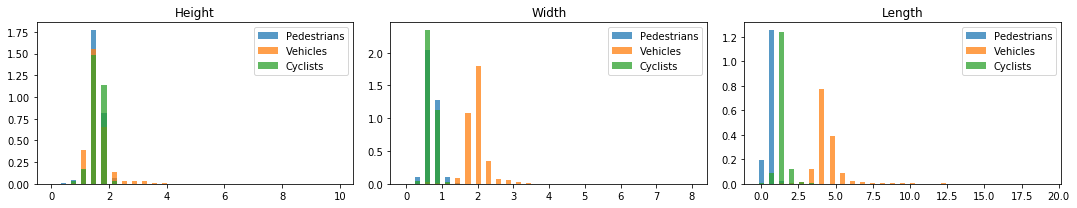

In [871]:
subs = [pedestrians[dimension_cols], vehicles[dimension_cols], cyclists[dimension_cols]]
labels = ["Pedestrians", "Vehicles", "Cyclists"]
plot_subgroup_multi_hist(objects_df[dimension_cols], subs, labels);

Let's inspect the differences between **Vehicle** and **Pedestrian** classes further.

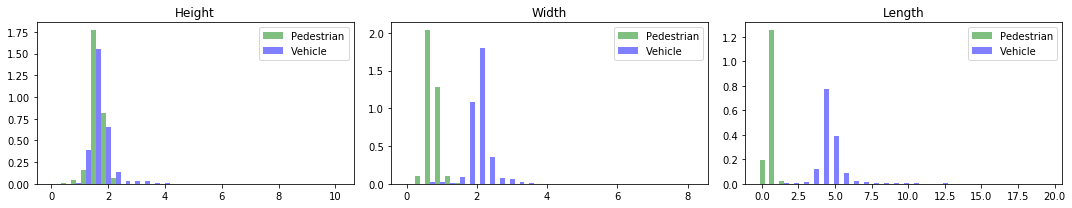

In [869]:
dimension_cols = ['dimension_height', 'dimension_width', 'dimension_length']
plot_subgroup_hist(objects_df[dimension_cols], pedestrians[dimension_cols], vehicles[dimension_cols]);

Generalizing, Pedestrians should be on sidewalks and crosswalks, and Vehicles should stay on the road. In theory, this could be expressed in the distribution of location and distance of these different object classes from the Waymo Car.

We can inspect that by plotting another histogram of the X and Y locations and the Distance of objects from the Waymo Car.

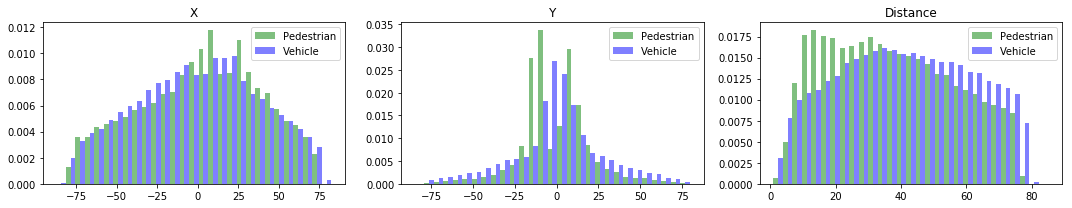

In [801]:
distance_cols = ['location_x', 'location_y', 'distance']
plot_subgroup_hist(objects_df[distance_cols], pedestrians[distance_cols], vehicles[distance_cols]);

In [364]:
res_lst = []
for i in range(100):
    res = sts.mannwhitneyu(pedestrians['dimension_width'].sample(100), vehicles['dimension_width'].sample(100))
    res_lst.append(res.pvalue)
print(np.mean(np.array([res_lst])))

res_lst = []
for i in range(100):
    res = sts.mannwhitneyu(pedestrians['dimension_length'].sample(100), vehicles['dimension_length'].sample(100))
    res_lst.append(res.pvalue)
print(np.mean(np.array([res_lst])))

res_lst = []
for i in range(100):
    res = sts.mannwhitneyu(pedestrians['dimension_height'].sample(100), vehicles['dimension_height'].sample(100))
    res_lst.append(res.pvalue)
print(np.mean(np.array([res_lst])))

3.744203150489021e-33
1.0036738829359239e-33
0.11666529214329543


p-values for **width** and **length** are both on the order of 1E-32 for vehicles versus pedestrians, confirming what we see in the plots above and know to be inherintly true: cars are wider and longer than humans.

However, the p-value for **height** is rather large (order of 1E-1), meaning that we cannot reject a null hypothesis that seems to often be true: humans are taller than cars. 


It looks like there may not be much of a difference in the distribution of Vehicles and Pedestrians in the X direction (which is in the direction of travel of the Waymo Car). 

However, upon carful inspection of the Y location, we see that the distribution of the Pedestrian class is roughly bimodal, and the Vehical class is roughly normal with a mean around zero. It also appears that Pedestrians tend to get a little closer to the Waymo Car than other Vehicles. 

We'll inspect these observations futher in the Hypothesis Testing section. 

In [366]:
res_lst = []
for i in range(100):
    res = sts.mannwhitneyu(pedestrians['location_x'].sample(100), vehicles['location_x'].sample(100))
    res_lst.append(res.pvalue)
print(np.mean(np.array([res_lst])))

res_lst = []
for i in range(100):
    res = sts.mannwhitneyu(pedestrians['location_y'].sample(100), vehicles['location_y'].sample(100))
    res_lst.append(res.pvalue)
print(np.mean(np.array([res_lst])))

res_lst = []
for i in range(100):
    res = sts.mannwhitneyu(pedestrians['distance'].sample(100), vehicles['distance'].sample(100))
    res_lst.append(res.pvalue)
print(np.mean(np.array([res_lst])))

0.22171993662958372
0.2184841254330128
0.14371760051967375


### Object Headings

The last attribute we have to inspect is the object **Heading**. Each heading is an angle from -180 to 180 degrees.

Let's take a look at the histogram of the Heading of the Vehicle class objects. Below, we've plotted a *circular* histogram, which should provide a more intuitive visualization since we're working with an angle measurement. 

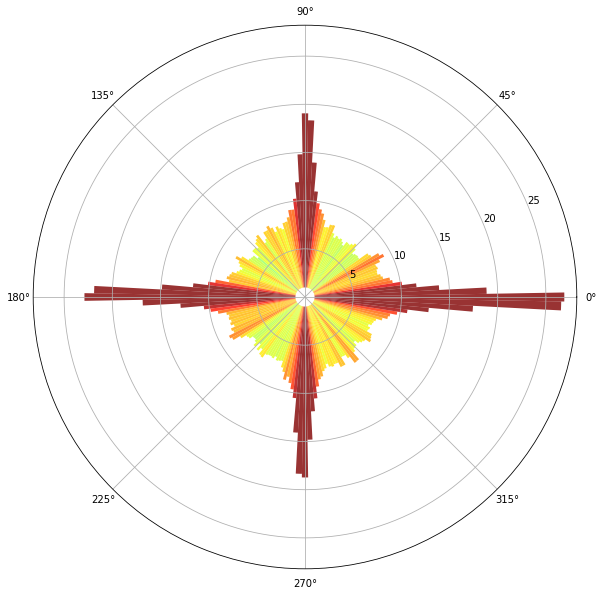

In [32]:
heights, angles, bars = plt.hist(vehicles['heading'], bins=180);
plt.close()
angles_rad = np.radians(angles)[:180]

fig, axs = plt.subplots(1,1, figsize=(10, 10))
N = 180
bottom = 1

theta = angles_rad
radii = (heights)**(1/np.pi)
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)
    #ax.set_title('Histogram of Vehicle Class Object Headings')
plt.savefig('vehicle_heading_hist.png',bbox_inches='tight')
plt.show()

In [182]:
pedestrians['dist'] = (pedestrians['heading']/90 - (pedestrians['heading']/90).round(0))*90
pedestrians[pedestrians['dist']<1].count()
#61207/112434

Unnamed: 0          61207
category            61207
dimension_height    61207
dimension_length    61207
dimension_width     61207
heading             61207
location_x          61207
location_y          61207
location_z          61207
distance            61207
dist                61207
dtype: int64

It looks like the Headings predominantly center around 0, 90, 180, and 270 degrees. This makes sense, considering these angles represent a heading where the Vehicle object instance is either parallel or orthogonal to the Waymo Car. Most cars on the road should be travelling in parellel to each other, with cars perpendicular to each other at intersections. 

Now let's take a look at the Headings of Pedestrican class objects. Although Pedestrians should be on the sidewalk or in a crosswalk, they have much more freedom than a car. Let's see how that freedom affects the Heading distribution of this class.

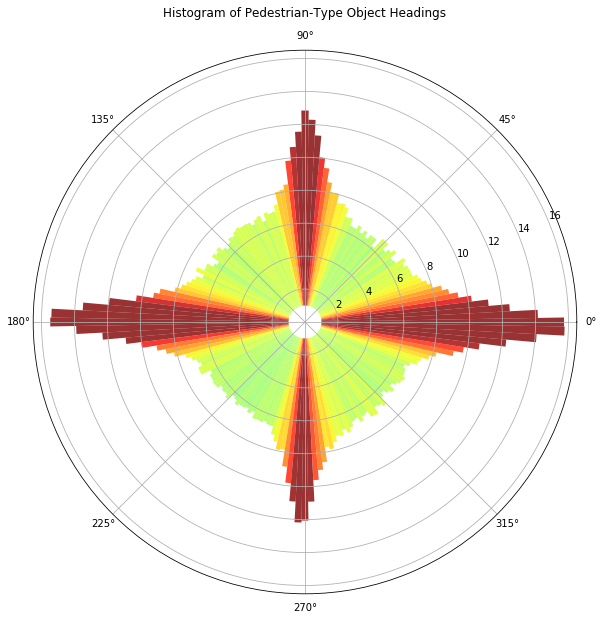

In [786]:
heights, angles, bars = plt.hist(pedestrians['heading'], bins=180);
plt.close()
angles_rad = np.radians(angles)[:180]

fig, axs = plt.subplots(1,1, figsize=(10, 10))
N = 180
bottom = 1

theta = angles_rad
radii = (heights)**(1/np.pi)
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)
    ax.set_title('Histogram of Pedestrian-Type Object Headings')

plt.show()



Although we still get peaks at 0, 90, 180, and 270 degrees, the distribution is less extreme. We have more Headings outside of our four 'right' angles. 

### Hypothesis Testing

Now that we're explored the data from our object instances, we can begin to investigate a few of the questions our analysis raised. The hypotheses we want to test are as follows:

1

2

3

In [180]:
vehicles['dist'] = (vehicles['heading']/90 - (vehicles['heading']/90).round(0))*90

0.7826311162503987


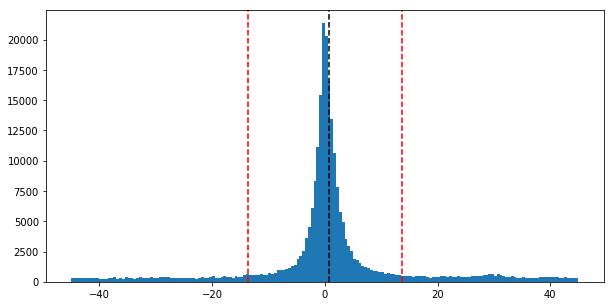

In [209]:
vehicles['dist'] = (vehicles['heading']/90 - (vehicles['heading']/90).round(0))*90

fig, ax = plt.subplots(1,1, figsize=(10, 5))
ax.hist(vehicles['dist'], bins=180)
ax.axvline(np.std(vehicles['dist']), color='red', linestyle='--')
ax.axvline(-np.std(vehicles['dist']), color='red', linestyle='--')
ax.axvline(np.mean(vehicles['dist']), color='black', linestyle='--')
plt.savefig('vehicle_heading_dist.png',bbox_inches='tight');

print(vehicles['dist'].mean())

In [55]:
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])

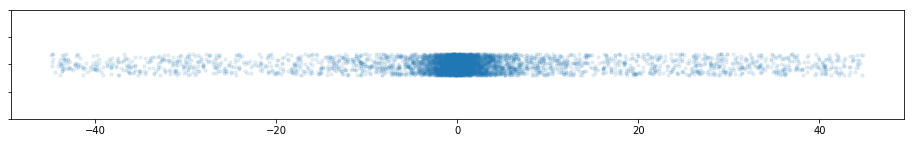

In [56]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(vehicles['dist'].sample(5000), ax, s=10, alpha=0.1)
#ax.set_title("One-Dimensional Scatterplot of Vehicle Headings with Respect to Waymo Car");
plt.savefig('vehicle_heading_1D.png',bbox_inches='tight');

In [291]:
heading_std_error = np.std(vehicles['dist']) / np.sqrt(vehicles['dist'].shape[0]) * 50
h0_dist = sts.norm(loc=0, scale=heading_std_error)

Text(0.5, 1.0, '$H_0$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car')

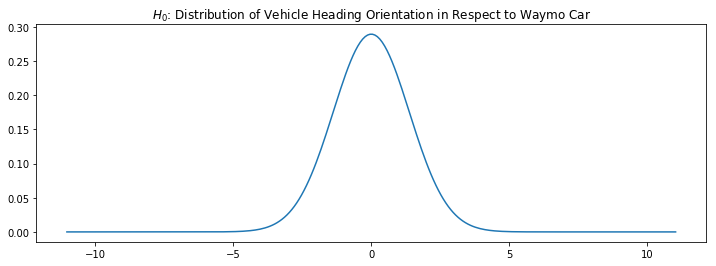

In [292]:
fig, ax = plt.subplots(figsize=(12, 4))

t = np.linspace(0 - 8*heading_std_error, 0 + 8*heading_std_error, num=250)
ax.plot(t, h0_dist.pdf(t))
ax.set_title("$H_0$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car")

In [311]:
ha_dist = sts.norm(loc=2.5, scale=heading_std_error)

In [312]:
def plot_heading_distributions(ax):
    t = np.linspace(0 - 8*heading_std_error, 0 + 8*heading_std_error, num=250)
    ax.plot(t, h0_dist.pdf(t))
    ax.plot(t, ha_dist.pdf(t))
    #plt.xlim(-0.005,0.005)

Text(0.5, 1.0, '$H_0$ and $H_a$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car')

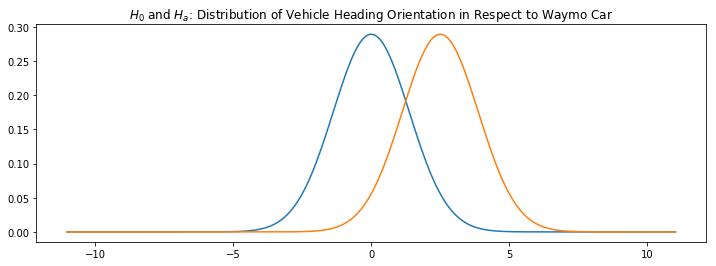

In [313]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_heading_distributions(ax)

ax.set_title("$H_0$ and $H_a$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car")

In [314]:
critical_value_right = h0_dist.ppf(1 - 0.025)
critical_value_left = h0_dist.ppf(0.025)

In [315]:
def plot_rejection_reigons(ax):
    t = np.linspace(0 - 6*heading_std_error, 0 + 6*heading_std_error, num=250)

    ax.axvline(critical_value_left, color="grey", linestyle="--")
    ax.axvline(critical_value_right, color="grey", linestyle="--")

    tpos = t[t >= critical_value_right]
    ax.fill_between(tpos, 0, h0_dist.pdf(tpos), alpha=0.2, label=r"$\alpha$")

    tneg = t[t <= critical_value_left]
    
    ax.axvline(vehicles['dist'].mean(), color='black', linewidth=2, linestyle="--")

    ax.fill_between(tneg, 0, h0_dist.pdf(tneg), alpha=0.2, label=r"$\alpha$")
    ax.set_title("$H_0$ and $H_a$: Distribution of Vehicle Heading Orientation in Respect to Waymo Car")
    plt.show()

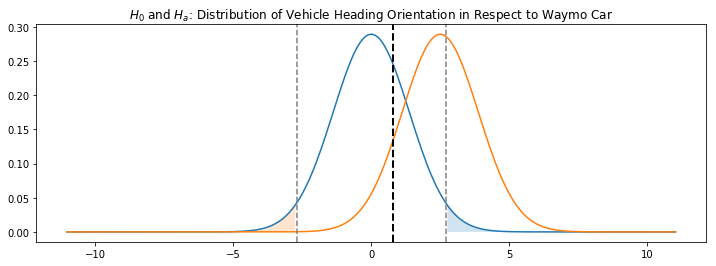

In [316]:
fig, ax = plt.subplots(figsize=(12, 4))

plot_heading_distributions(ax)
plot_rejection_reigons(ax)

We are outside the rejection region, and do not have sufficient evidence to reject the null hypothesis.

In [317]:
standard_critical_value = sts.norm().ppf(1 - 0.025)

left_endpoint = np.mean(vehicles['dist']) - standard_critical_value*heading_std_error
right_endpoint = np.mean(vehicles['dist']) + standard_critical_value*heading_std_error

print("95% Confidence Interval for Sample Mean: [{:2.5f}, {:2.5f}]".format(
    left_endpoint, right_endpoint))

95% Confidence Interval for Sample Mean: [-1.91842, 3.48368]


There is a 95% chance that the above interval contains the true mean of Vehicle Class Headings. Since the interval contains the null assumption that $\mu_{\text{0}} = 0$, we cannot conclude from the confidence interval that the true mean is different than 0.

In [318]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sts.sem(a)
    h = se * sts.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mean_confidence_interval(vehicles['dist'])

(0.7826311162503987, 0.7116348816429565, 0.8536273508578409)

Above we calculated the mean 95% confident interval from the entire Vehicle Class sample.

In [319]:
def plot_power_reigons(ax):
    t = np.linspace(np.mean(vehicles['dist']) - 10*heading_std_error, np.mean(vehicles['dist']) + 10*heading_std_error, num=250)

    ax.axvline(critical_value_left, color="grey", linestyle="--")
    ax.axvline(critical_value_right, color="grey", linestyle="--")

    tpos = t[t >= critical_value_right]
    ax.fill_between(tpos, 0, ha_dist.pdf(tpos), alpha=0.2, label=r"$\alpha$")

    tneg = t[t <= critical_value_left]
    ax.fill_between(tneg, 0, ha_dist.pdf(tneg), alpha=0.2, label=r"$\alpha$")

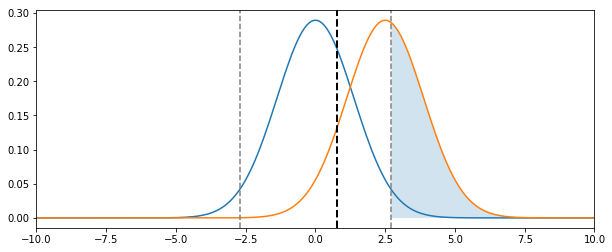

In [320]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_heading_distributions(ax)
plot_power_reigons(ax)
ax.axvline(vehicles['dist'].mean(), color='black', linewidth=2, linestyle="--")
ax.set_xlim(-10,10)
plt.savefig('hyp_testing_plot.png',bbox_inches='tight');
#ax.set_title("$H_0$ and $H_a$ Distribution of Heading Orientation");

In [303]:
power = ha_dist.cdf(critical_value_left) + (1 - ha_dist.cdf(critical_value_right))

print("Power to Detect Effect: {:2.3f}".format(power))

Power to Detect Effect: 0.664


There is a 66% chance we will detect a difference of 5 degrees from a true straight or right angle, when such a difference actually exists.

In [202]:
vehicle_heading = vehicles['heading']/90 - (vehicles['heading']/90).round(0)
pedestrian_heading = pedestrians['heading']/90 - (pedestrians['heading']/90).round(0)

In [203]:
stat, p_val = sts.ttest_ind(vehicle_heading, pedestrian_heading, equal_var=False)
print('The statistic is: {} \nP-value: {}'.format(stat ,p_val))

The statistic is: 2.4630471612283933 
P-value: 0.013777088066573


Text(0.5, 1.0, 'Distribution of Vehicle Heading')

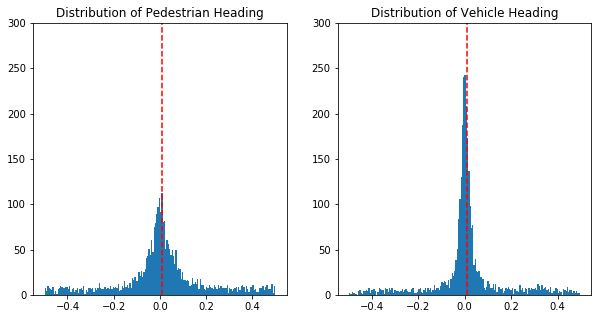

In [205]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(pedestrian_heading.sample(3000), bins=180);
ax[0].axvline(np.mean(pedestrian_heading), color='red', linestyle='--')
ax[0].set_ylim(0,300)
ax[0].set_title('Distribution of Pedestrian Heading')

ax[1].hist(vehicle_heading.sample(3000), bins=180);
#ax[1].axvline(np.std(vehicles['dist']), color='red', linestyle='--')
#ax[1].axvline(-np.std(vehicles['dist']), color='red', linestyle='--')
ax[1].axvline(vehicle_heading.mean(), color='red', linestyle='--')
ax[1].set_ylim(0,300)
ax[1].set_title('Distribution of Vehicle Heading')

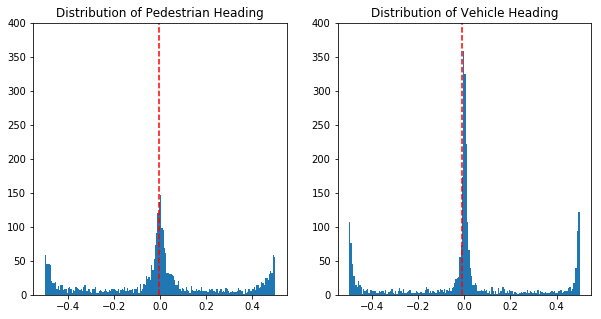

In [165]:
vehicle_heading = vehicles['heading']/180 - (vehicles['heading']/180).round(0)
pedestrian_heading = pedestrians['heading']/180 - (pedestrians['heading']/180).round(0)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].hist(pedestrian_heading.sample(3000), bins=180);
#ax[0].axvline(np.std(pedestrian_heading), color='red', linestyle='--')
#ax[0].axvline(-np.std(pedestrian_heading), color='red', linestyle='--')
ax[0].axvline(pedestrian_heading.mean(), color='red', linestyle='--')
ax[0].set_ylim(0,400)
ax[0].set_title('Distribution of Pedestrian Heading')

ax[1].hist(vehicle_heading.sample(3000), bins=180);
#ax[1].axvline(np.std(vehicles['dist']), color='red', linestyle='--')
#ax[1].axvline(-np.std(vehicles['dist']), color='red', linestyle='--')
ax[1].axvline(vehicle_heading.mean(), color='red', linestyle='--')
ax[1].set_ylim(0,400)
ax[1].set_title('Distribution of Vehicle Heading');

In [168]:
stat, p_val = sts.ttest_ind(vehicle_heading, pedestrian_heading, equal_var=False)
print('The statistic is: {} \nP-value: {}'.format(stat, p_val))

The statistic is: -4.7855148739785145 
P-value: 1.7066050980628102e-06
